# Klasyfikacja ryzyka cukrzycy na podstawie wskaźników zdrowotnych

## Autorzy
- Filip Obuchowicz   s223421
- Kamil Pizon        s223434

## Streszczenie
Projekt dotyczy budowy i porównania modeli klasyfikacyjnych służących do przewidywania ryzyka cukrzycy na podstawie danych BRFSS2015. W pierwszym etapie przeprowadzono wstępną analizę danych, obejmującą m.in. ocenę rozkładów zmiennych oraz identyfikację problemu niezbalansowanych klas. Następnie zastosowano transformacje, takie jak logarytmowanie zmiennych o silnej skośności oraz skalowanie cech za pomocą MinMaxScaler, co pozwoliło na ujednolicenie zakresów wartości i poprawę działania algorytmów wrażliwych na skalę. Aby poradzić sobie z niezbalansowaniem klas, wykorzystano technikę SMOTE, która zrównoważyła liczebność przypadków pozytywnych i negatywnych w zbiorze treningowym.

W kolejnym kroku zbudowano i porównano cztery modele: k-Najbliższych Sąsiadów (KNN), Drzewo Decyzyjne, Las Losowy oraz model hybrydowy, który łączy predykcje trzech poprzednich metod. Ocena skuteczności modeli została przeprowadzona na podstawie kluczowych metryk, takich jak Accuracy, F1-Score dla klasy pozytywnej oraz AUC. Dodatkowo, stabilność i zdolność generalizacji modeli zweryfikowano przy użyciu walidacji krzyżowej. Na koniec zaprezentowano praktyczne zastosowanie modeli na sztucznie wygenerowanych obserwacjach.

## Słowa kluczowe:
Cukrzyca, Klasyfikacja, Uczenie Maszynowe, KNN, Drzewo Decyzyjne, Las Losowy, Model Hybrydowy, Analiza Danych (EDA), SMOTE, Walidacja Krzyżowa


## 1. Wprowadzenie
Cukrzyca to globalny problem zdrowotny. Wczesne wykrycie ryzyka jest kluczowe dla zapobiegania powikłaniom. Modele predykcyjne oparte na uczeniu maszynowym mogą pomóc w identyfikacji osób zagrożonych, umożliwiając wczesną interwencję. Projekt skupia się na zastosowaniu takich modeli na danych BRFSS, aby klasyfikować ryzyko cukrzycy.

### 1.1 Przedmiot badania
Dane `diabetes_012_health_indicators_BRFSS2015.csv` z badania BRFSS 2015, zawierające wskaźniki zdrowotne i demograficzne. Zmienna docelowa `Diabetes_012` (brak cukrzycy, stan przedcukrzycowy, cukrzyca) zostanie przekształcona na binarną: 0 (brak cukrzycy) vs 1 (stan przedcukrzycowy/cukrzyca).

### 1.2 Cel
Opracowanie, trening i ocena modeli klasyfikacyjnych do przewidywania binarnego ryzyka cukrzycy. Porównanie wydajności algorytmów KNN, Drzewa Decyzyjnego, Lasu Losowego i modelu hybrydowego. Identyfikacja kluczowych zmiennych oraz demonstracja działania modeli.

## 2. Przygotowanie środowiska

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
RANDOM_STATE=42

## 3. Wstępna analiza danych

### 3.1 Przedstawienie dostępnych zmiennych
Dane BRFSS2015 (253,680 obserwacji, 22 zmienne). Zmienna `Diabetes_012` transformowana: 0 (brak cukrzycy), 1 (ryzyko: stan przedcukrzycowy/cukrzyca).

In [300]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df['Diabetes_012'] = df['Diabetes_012'].replace({1: 1, 2: 1})
print("Pierwsze 5 wierszy danych:")
print(df.head())


Pierwsze 5 wierszy danych:
   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0

Wszystkie zmienne są numeryczne (float64). Mamy 21 zmiennych objaśniających:

* **Binarne (0/1):** `HighBP`, `HighChol`, `Smoker`, `PhysActivity`, `Sex` itp. (łącznie 14 zmiennych, np. `CholCheck`, `Stroke`, `HeartDiseaseorAttack`, `Fruits`, `Veggies`, `HvyAlcoholConsump`, `AnyHealthcare`, `NoDocbcCost`, `DiffWalk`).
* **Kategoryczne/Porządkowe:** `GenHlth` (ogólny stan zdrowia, 1-5), `Age` (kategoria wiekowa, 1-13), `Education` (poziom edukacji, 1-6), `Income` (poziom dochodu, 1-8).
* **Liczbowe:**  `MentHlth` (dni złego samopoczucia psychicznego, 0-30), `PhysHlth` (dni złego samopoczucia fizycznego, 0-30)
* **Ciągłe:** `BMI` (wskaźnik masy ciała).

### 3.2 Statystyki opisowe
Analiza podstawowych statystyk, w tym skośności, dla zrozumienia rozkładów zmiennych.

In [301]:
binary_cols = [col for col in df.columns if set(df[col].unique()) <= {0, 1}]
non_binary_cols = [col for col in df.columns if col not in binary_cols]

desc = df[non_binary_cols].describe().T
desc["skewness"] = df[non_binary_cols].skew()
print(desc[["mean", "50%", "min", "max", "std", "skewness"]].round(2))

            mean   50%   min   max   std  skewness
BMI        28.38  27.0  12.0  98.0  6.61      2.12
GenHlth     2.51   2.0   1.0   5.0  1.07      0.42
MentHlth    3.18   0.0   0.0  30.0  7.41      2.72
PhysHlth    4.24   0.0   0.0  30.0  8.72      2.21
Age         8.03   8.0   1.0  13.0  3.05     -0.36
Education   5.05   5.0   1.0   6.0  0.99     -0.78
Income      6.05   7.0   1.0   8.0  2.07     -0.89


**Interpretacja:**  
`Diabetes_012` ma średnią ~0.16 i skośność 1.88, co potwierdza silne niezbalansowanie klas (przewaga klasy 0). Zmienne `BMI`, `MentHlth`, `PhysHlth` wykazują prawostronną skośność (BMI ~2.13, MentHlth ~2.77, PhysHlth ~2.53), co uzasadniało zastosowanie transformacji logarytmicznej. Większość zmiennych binarnych ma skośność bliską zeru, co oznacza równomierniejszy rozkład tych cech w populacji.

### 3.3 Podstawowa wizualizacja danych
Wizualizacje pomagają zrozumieć rozkłady poszczególnych zmiennych oraz zidentyfikować potencjalne relacje między zmiennymi objaśniającymi a zmienną docelową.

#### Rozkład zmiennej docelowej `Diabetes_012`

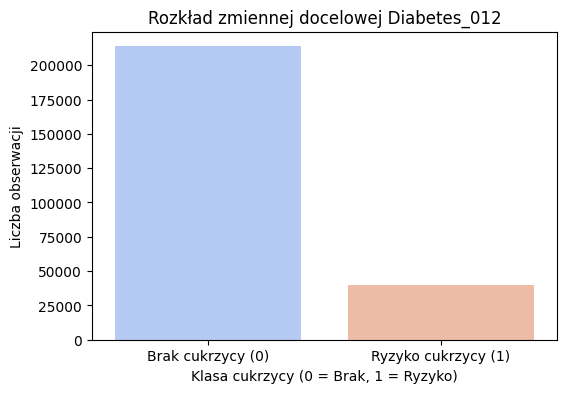

Diabetes_012
0.0    0.842
1.0    0.158
Name: proportion, dtype: float64


In [302]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Diabetes_012', data=df, palette='coolwarm')
plt.title('Rozkład zmiennej docelowej Diabetes_012')
plt.xlabel('Klasa cukrzycy (0 = Brak, 1 = Ryzyko)')
plt.ylabel('Liczba obserwacji')
plt.xticks([0, 1], ['Brak cukrzycy (0)', 'Ryzyko cukrzycy (1)'])
plt.show()
print(df['Diabetes_012'].value_counts(normalize=True).round(3))

**Interpretacja:** Wykres potwierdza niezbalansowanie klas: ~84.2% to klasa '0' (brak cukrzycy), ~15.8% to klasa '1' (ryzyko). Uzasadnia to użycie SMOTE.

#### Histogramy dla zmiennych numerycznych i porządkowych
Poniżej znajdują się histogramy dla zmiennych, które nie są ściśle binarne, aby pokazać ich rozkłady.

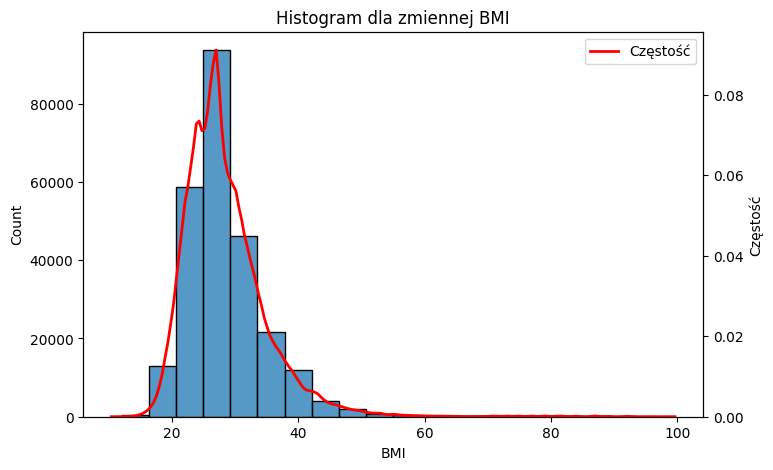

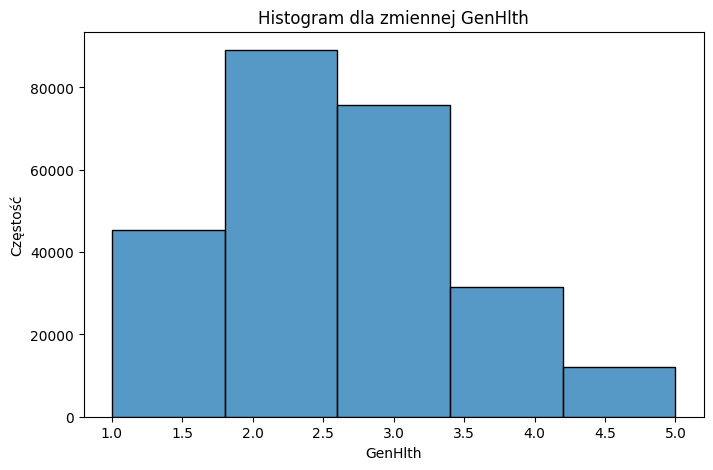

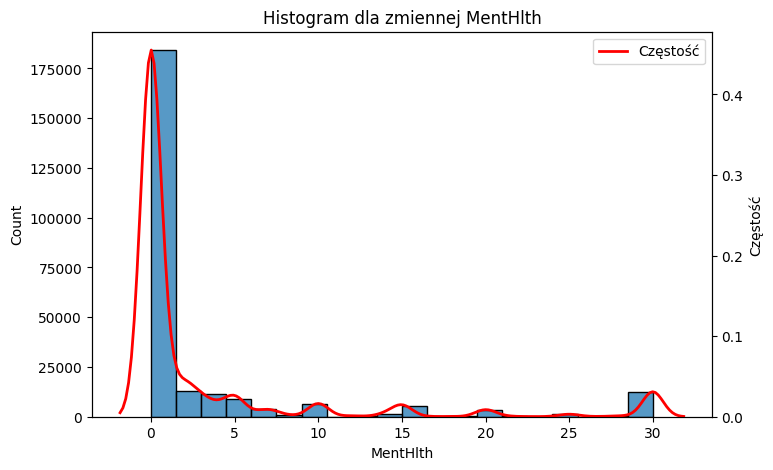

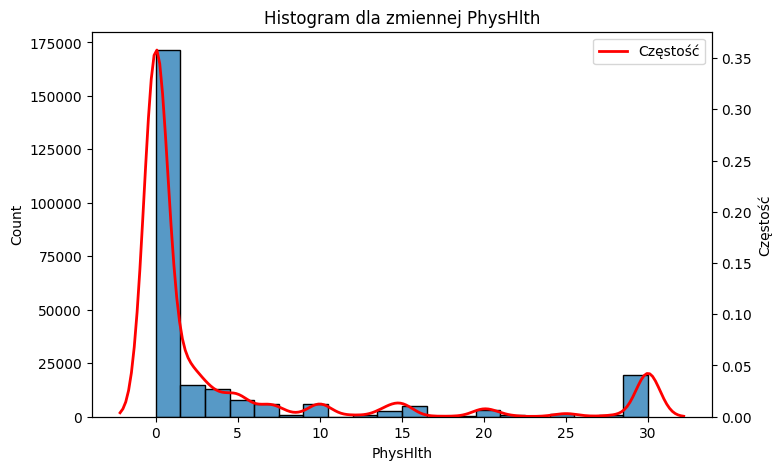

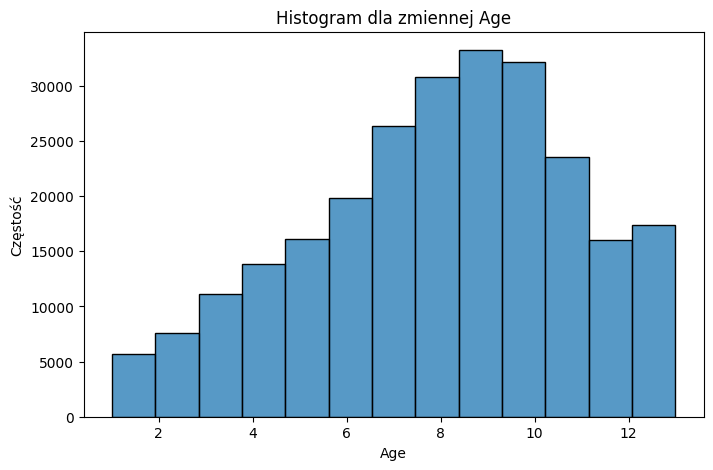

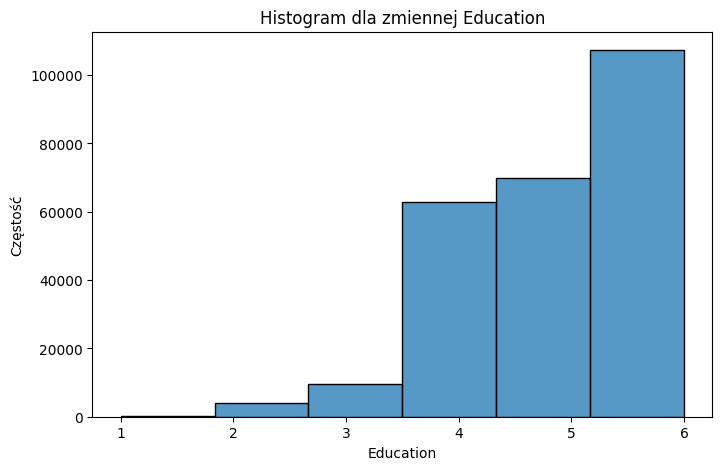

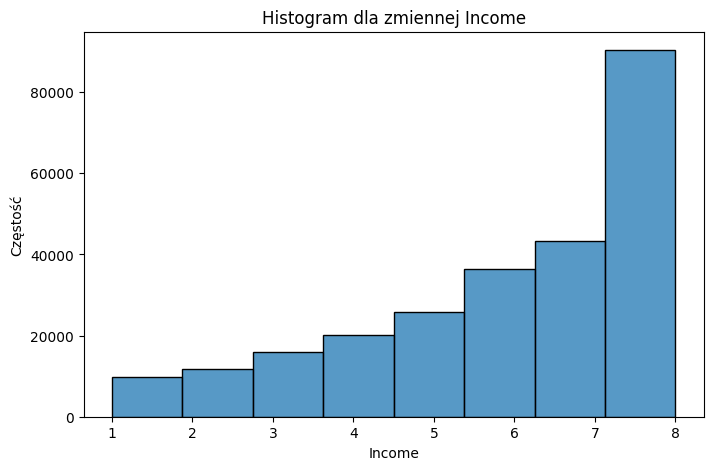

In [303]:
non_binary_cols = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
for col in non_binary_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], bins=20 if df[col].nunique() > 15 else df[col].nunique(), palette='coolwarm', stat='count', edgecolor='black')
    if col in ['BMI', 'MentHlth', 'PhysHlth']:
        ax2 = plt.gca().twinx()
        sns.kdeplot(df[col], color='red', ax=ax2, linewidth=2, label='Częstość')
        ax2.set_ylabel('Częstość')
        ax2.legend(loc='upper right')
    plt.title(f'Histogram dla zmiennej {col}')
    plt.xlabel(col)
    plt.ylabel('Częstość')
    plt.show()

**Interpretacja histogramów:**
Analizując poszczególne histogramy, można zauważyć:
* `BMI`, `MentHlth`, `PhysHlth`: Rozkłady są silnie prawostronnie skośne, co sugeruje, że większość obserwacji ma niższe wartości, ale istnieją wartości znacznie wyższe. To potwierdza potrzebę transformacji logarytmicznej dla tych zmiennych.
* `GenHlth`: Najwięcej obserwacji koncentruje się wokół wartości 2 i 3 (oceny "bardzo dobry" i "dobry" stan zdrowia).
* `Age`: Rozkład jest stosunkowo równomierny w środkowych kategoriach wiekowych, z mniejszą liczbą obserwacji w najmłodszych i najstarszych grupach.
* `Education`, `Income`: Pokazują zróżnicowanie w populacji pod względem poziomu wykształcenia i dochodu.

#### Boxploty dla zmiennych numerycznych i porządkowych
Wykresy pudełkowe pokazują, jak rozkłady tych zmiennych różnią się między grupą bez ryzyka cukrzycy (0) a grupą z ryzykiem (1).

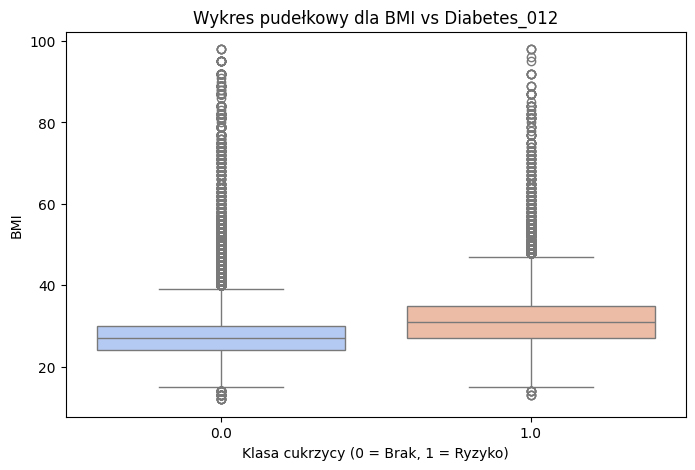

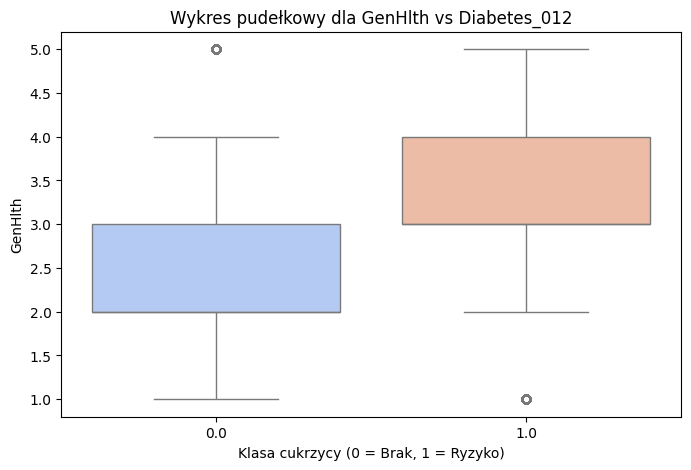

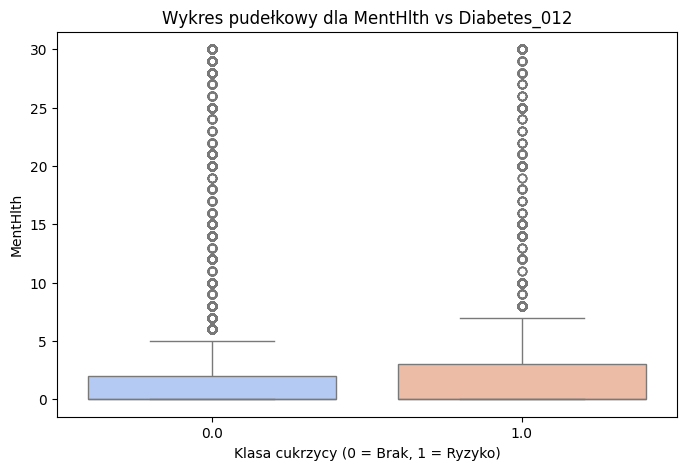

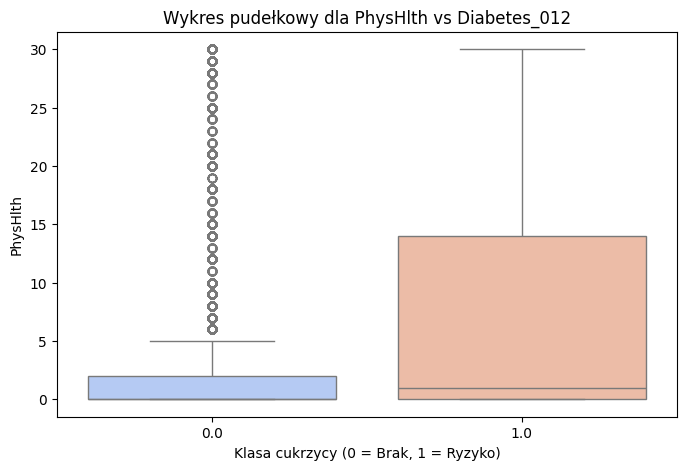

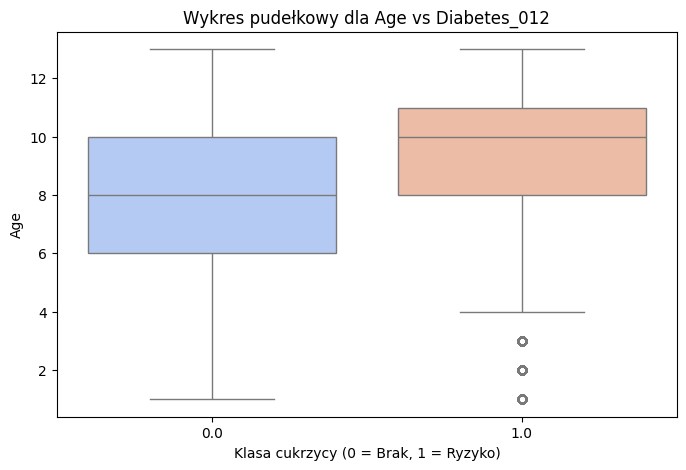

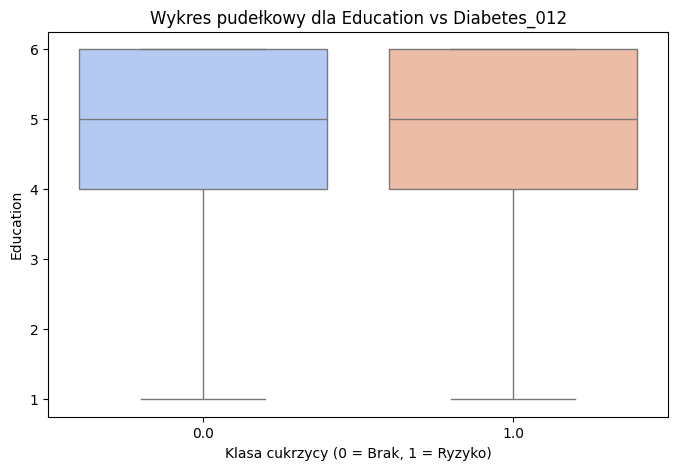

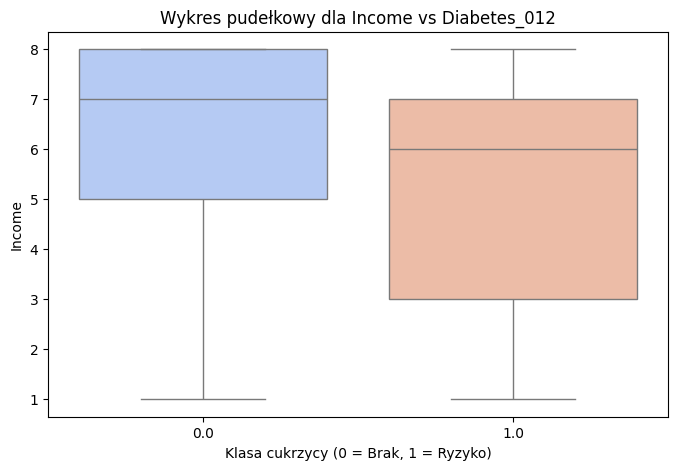

In [304]:
for col in non_binary_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Diabetes_012', y=col, data=df, palette='coolwarm')
    plt.title(f'Wykres pudełkowy dla {col} vs Diabetes_012')
    plt.xlabel('Klasa cukrzycy (0 = Brak, 1 = Ryzyko)')
    plt.ylabel(col)
    plt.show()

**Interpretacja wykresów pudełkowych:**
Wykresy pudełkowe dla poszczególnych zmiennych w podziale na klasy `Diabetes_012` dostarczają następujących obserwacji:
* `BMI`, `Age`, `GenHlth` (wyższe wartości oznaczają gorsze zdrowie): Mediany tych zmiennych są wyraźnie wyższe dla grupy z ryzykiem cukrzycy (klasa 1).
* `MentHlth`, `PhysHlth`: Podobnie, osoby z grupy ryzyka zgłaszają wyższe mediany dni złego samopoczucia psychicznego i fizycznego.
* `Income`, `Education`: Dla tych zmiennych można zaobserwować tendencję, że niższe poziomy dochodu i edukacji są częściej związane z grupą ryzyka, choć różnice mogą być mniej wyraźne niż dla poprzednich zmiennych.
Te różnice w rozkładach potwierdzają potencjalną wartość predykcyjną tych zmiennych.

**Interpretacja wykresów słupkowych dla zmiennych binarnych:**
Analizując wykresy dla zmiennych binarnych (np. `HighBP`, `HighChol`, `Smoker`, `PhysActivity`):
* Można zaobserwować, jaka jest proporcja osób z cukrzycą (lub ryzykiem) w zależności od tego, czy dana cecha występuje (wartość 1) czy nie (wartość 0).
* Przykładowo, dla `HighBP` (wysokie ciśnienie krwi), w grupie osób z `HighBP = 1` odsetek osób z ryzykiem cukrzycy jest wyraźnie wyższy niż w grupie z `HighBP = 0`.
* Podobne analizy można przeprowadzić dla pozostałych zmiennych binarnych, identyfikując te, które silniej różnicują grupy pod względem ryzyka cukrzycy.

### Macierz korelacji
Macierz korelacji to narzędzie statystyczne służące do oceny siły i kierunku liniowych zależności pomiędzy wszystkimi parami zmiennych numerycznych w zbiorze danych. Każda komórka tej tabeli zawiera współczynnik korelacji Pearsona, który przyjmuje wartości od -1 do 1. Wartość bliska 1 oznacza silną dodatnią zależność liniową, bliska -1 – silną ujemną, a wartość bliska 0 – brak liniowej zależności. Macierz korelacji pokazuje, jak bardzo zmiany jednej zmiennej są powiązane ze zmianami drugiej, a więc jest podstawowym narzędziem eksploracyjnej analizy danych, ułatwiającym interpretację relacji pomiędzy cechami. Poniżej przedstawiona zostanie macierz korelacji dla wszystkich zmiennych numerycznych w zbiorze danych po przeskalowaniu. Pozwoli ona zidentyfikować najsilniejsze zależności pomiędzy cechami oraz wskazać, które zmienne są najbardziej 

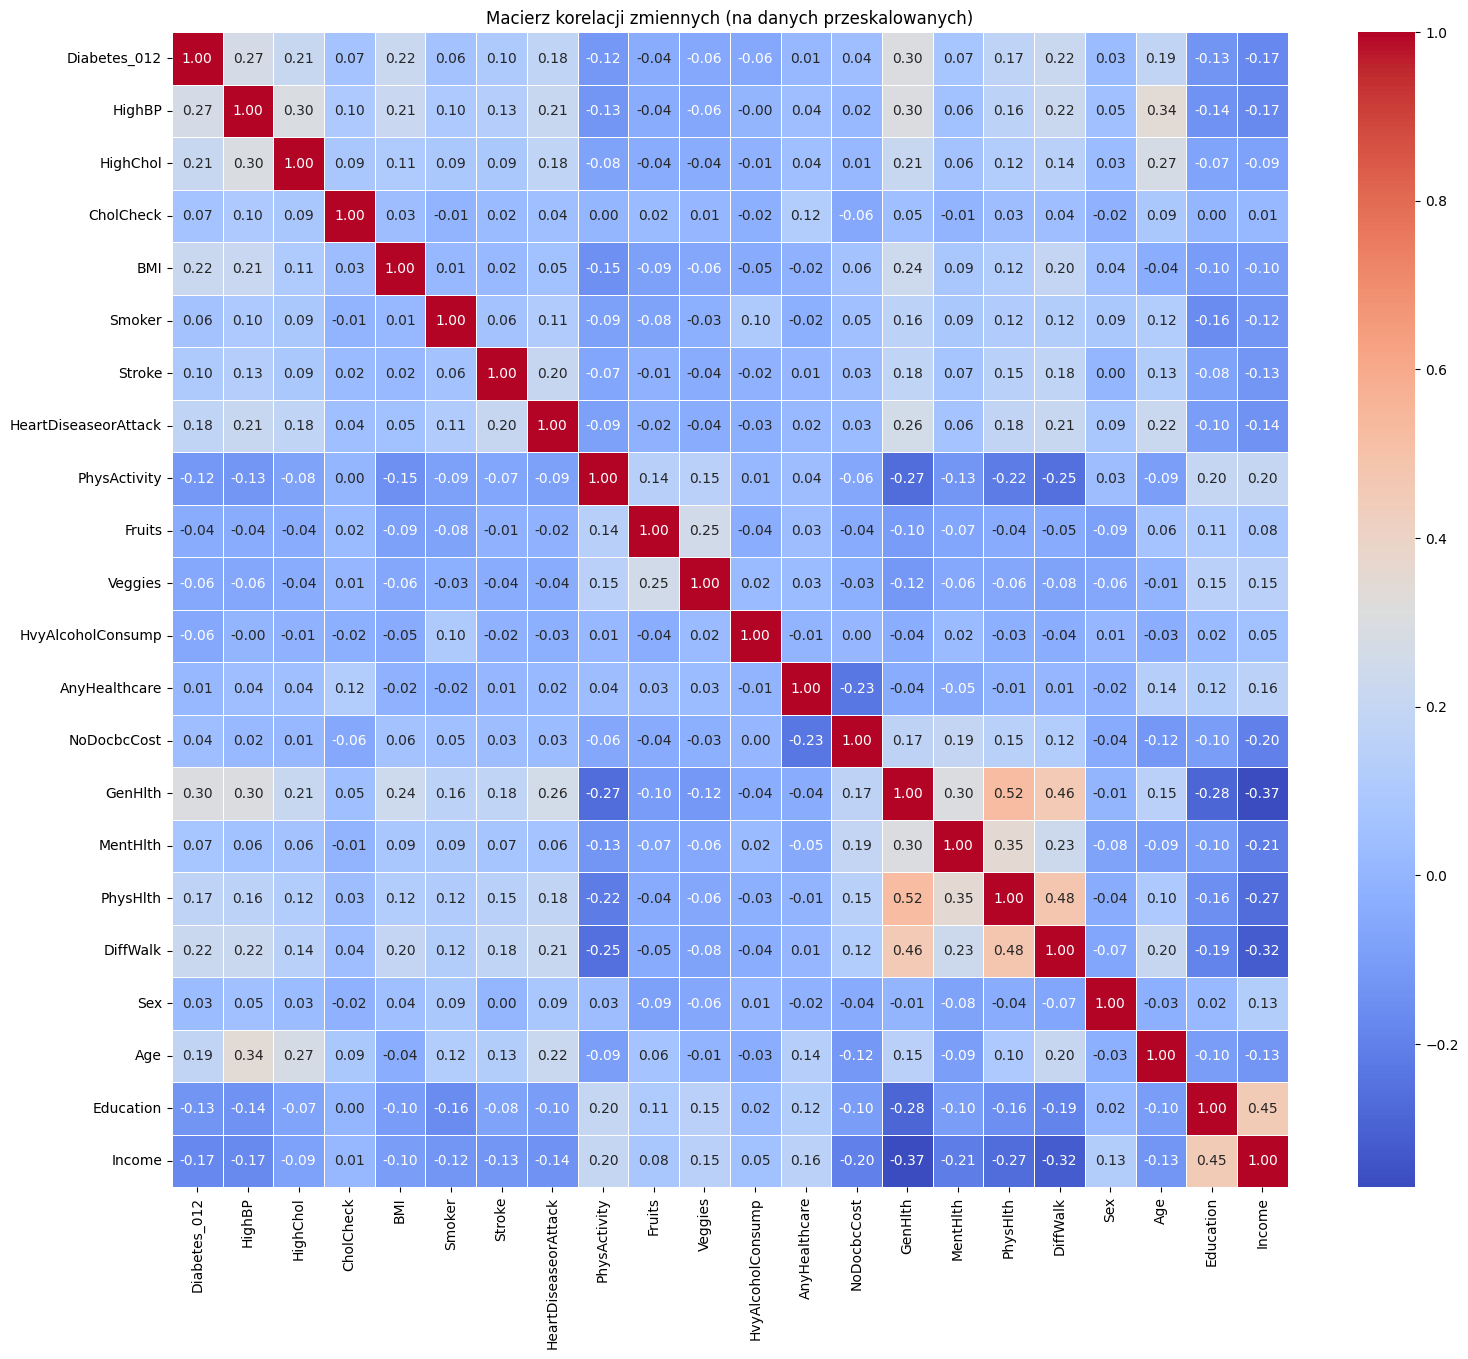

Korelacje z Diabetes_012 (top 5 dodatnich i ujemnych):
Diabetes_012    1.000000
GenHlth         0.300785
HighBP          0.270334
BMI             0.223851
DiffWalk        0.222155
Name: Diabetes_012, dtype: float64
Income              -0.172794
Education           -0.131803
PhysActivity        -0.121392
Veggies             -0.059219
HvyAlcoholConsump   -0.056682
Name: Diabetes_012, dtype: float64


In [305]:
df_for_corr = df
plt.figure(figsize=(18, 15))
sns.heatmap(df_for_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Macierz korelacji zmiennych (na danych przeskalowanych)')
plt.show()
print("Korelacje z Diabetes_012 (top 5 dodatnich i ujemnych):")
print(df_for_corr.corr()['Diabetes_012'].sort_values(ascending=False).head())
print(df_for_corr.corr()['Diabetes_012'].sort_values(ascending=True).head())

**Interpretacja:** `GenHlth`, `BMI` (po transformacji i skalowaniu), `HighBP` mają najwyższe dodatnie korelacje z `Diabetes_012`. `Income`, `PhysActivity`, `Education` mają najwyższe ujemne korelacje. Istnieją też korelacje między zmiennymi objaśniającymi, ale nie na tyle silne, by wskazywać na poważną współliniowość.

### 3.4 Transformacje danych

#### Logarytmowanie zmiennych skośnych (`BMI`, `MentHlth`, `PhysHlth`)

In [306]:
skewed_cols = ['BMI', 'MentHlth', 'PhysHlth']
for col in skewed_cols:
    if df[col].max() > 35: 
        df[col] = np.log1p(df[col])

print("\nSkośność po (ewentualnej) transformacji:")
print(df[skewed_cols].skew().round(2))


Skośność po (ewentualnej) transformacji:
BMI         0.72
MentHlth    2.72
PhysHlth    2.21
dtype: float64


**Interpretacja:** Logarytmowanie (jeśli zostało zastosowane) powinno znacząco zredukować skośność dla `BMI`, `MentHlth` i `PhysHlth`.

### Skalowanie cech – MinMaxScaler

Skalowanie cech polega na przekształceniu wszystkich zmiennych wejściowych do wspólnego zakresu, najczęściej [0, 1], co jest kluczowe dla algorytmów wrażliwych na skalę (np. kNN). W projekcie użyto MinMaxScaler z `sklearn`, dopasowanego wyłącznie na zbiorze treningowym, aby uniknąć wycieku informacji. Następnie te same parametry skalowania zastosowano do zbioru testowego. Dzięki temu wszystkie cechy mają równy wpływ na modele, a proces uczenia pozostaje wiarygodny i poprawny.


In [307]:
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE,stratify=y)
scaler=MinMaxScaler()
X_train_scaled=scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
print("Przeskalowane dane treningowe (pierwsze 3 wiersze):")
print(X_train_scaled.head(3).round(2))
print("Przeskalowane dane testowe (pierwsze 3 wiersze):")
print(X_test_scaled.head(3).round(2))

Przeskalowane dane treningowe (pierwsze 3 wiersze):
   HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0        1.0  0.40     0.0     0.0                   1.0   
1     0.0       0.0        1.0  0.32     0.0     0.0                   0.0   
2     1.0       1.0        1.0  0.67     1.0     0.0                   1.0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0           0.0     1.0      1.0  ...            1.0          1.0     0.75   
1           1.0     0.0      1.0  ...            1.0          0.0     0.50   
2           0.0     0.0      1.0  ...            1.0          0.0     0.75   

   MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  Income  
0      0.00      0.17       1.0  1.0  1.00        0.8    0.71  
1      0.17      0.33       0.0  1.0  0.58        1.0    1.00  
2      0.07      0.47       1.0  0.0  0.58        0.6    0.43  

[3 rows x 21 columns]
Przeskalowane dane testowe (pierwsze 3 wier

### Zastosowanie SMOTE

Najpierw dane zostały podzielone na zbiór treningowy (80%) i testowy (20%). Problem niezbalansowanych klas rozwiązano poprzez zastosowanie techniki SMOTE wyłącznie na zbiorze treningowym, co pozwoliło na zrównoważenie liczebności klas do proporcji 1:1. Dzięki temu modele uczone były na zbalansowanych danych, a ocena skuteczności odbywała się na oryginalnym, niezbalansowanym zbiorze testowym, co zapobiega wyciekowi informacji i zapewnia wiarygodność wyników.

In [308]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"Rozkład klas w y_train: \n{y_train.value_counts(normalize=True)}")
print(f"\nRozkład klas w y_train_smote: \n{y_train_resampled.value_counts(normalize=True)}")


Rozkład klas w y_train: 
Diabetes_012
0.0    0.84241
1.0    0.15759
Name: proportion, dtype: float64

Rozkład klas w y_train_smote: 
Diabetes_012
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


### 3.5 Braki danych

W analizowanym projekcie nie wystąpiły żadne braki danych – wszystkie rekordy w zbiorze BRFSS2015 były kompletne. Przed rozpoczęciem dalszych etapów przetwarzania sprawdzono liczbę brakujących wartości i potwierdzono, że nie występują puste komórki. Dzięki temu nie było potrzeby stosowania technik imputacji ani eliminowania obserwacji. Całość analiz oraz budowa modeli została przeprowadzona na pełnym, niezmienionym pod względem kompletności zbiorze danych.



In [309]:
print(f"Suma brakujących wartości: {df.isnull().sum().sum()}")

Suma brakujących wartości: 0


**Interpretacja:** Braków danych nie stwierdzono.

### 3.6 Obserwacje odstające
Zmienne takie jak BMI, MentHlth oraz PhysHlth charakteryzują się szerokim zakresem wartości, co oznacza, że w zbiorze danych mogą występować obserwacje znacznie odbiegające od typowych (tzw. obserwacje odstające). Zamiast usuwać te wartości, zdecydowaliśmy się na zastosowanie odpowiednich transformacji, takich jak logarytmowanie, a następnie skalowanie danych. Takie podejście pozwala ograniczyć wpływ ekstremalnych wartości na proces uczenia modeli, poprawiając stabilność i skuteczność predykcji. Warto również podkreślić, że wybrane przez nas algorytmy drzewiaste (np. Drzewo Decyzyjne, Las Losowy) są z natury mniej wrażliwe na obecność obserwacji odstających, dzięki czemu nie wymagają one tak rygorystycznego oczyszczania danych jak metody oparte na odległościach.

## 4. Opis metod
Zastosowano trzy podstawowe algorytmy klasyfikacyjne oraz model hybrydowy, tworząc łącznie cztery mechanizmy decyzyjne.

#### 4.1 kNN (k=5)

**Opis ogólny działania metody:**
Algorytm k Najbliższych Sąsiadów jest nieparametryczną metodą uczenia nadzorowanego, która klasyfikuje nową obserwację na podstawie klasy większościowej wśród jej k najbliższych sąsiadów w przestrzeni cech. "Uczenie" w kNN polega jedynie na zapamiętaniu całego zbioru treningowego, dlatego nazywany jest algorytmem "leniwym". Podczas predykcji, dla nowego punktu obliczane są odległości do wszystkich punktów treningowych, wybieranych jest k najbliższych, a następnie odbywa się głosowanie większościowe. Wybór wartości k oraz metryki odległości (tu: Euklidesowa) jest kluczowy, a algorytm jest wrażliwy na skalowanie cech, co zostało zaadresowane przez MinMaxScaler. W tym projekcie przyjęto k=5.

**Cytowanie pracy:**
Fix, E., & Hodges, J. L. (1951). *Discriminatory Analysis. Nonparametric Discrimination: Consistency Properties.* USAF School of Aviation Medicine, Randolph Field, Texas.

#### 4.2 Drzewo Decyzyjne

**Opis ogólny działania metody:**
Drzewa decyzyjne modelują proces podejmowania decyzji jako hierarchiczną strukturę, gdzie węzły wewnętrzne reprezentują testy na atrybutach, a liście etykiety klas. Budowa drzewa odbywa się poprzez rekurencyjny podział zbioru danych, dążąc do maksymalizacji "czystości" klas w węzłach potomnych, często przy użyciu miar takich jak entropia czy wskaźnik Giniego. Proces ten przebiega zwykle metodą "top-down greedy approach". Główną zaletą drzew decyzyjnych jest ich wysoka interpretowalność, pozwalająca na zrozumienie ścieżki decyzyjnej. Wadą jest natomiast podatność na nadmierne dopasowanie do danych treningowych, co może ograniczać ich zdolność generalizacji.

**Cytowanie pracy:**
Quinlan, J. R. (1986). *Induction of decision trees.* Machine learning, 1(1), 81-106.

#### 4.3 Las Losowy

**Opis ogólny działania metody:**
Las losowy to metoda zespołowa, która buduje wiele drzew decyzyjnych w celu poprawy dokładności i redukcji nadmiernego dopasowania. Każde drzewo w lesie jest trenowane na losowej próbce danych treningowych uzyskanej metodą bootstrap (bagging) oraz przy losowym wyborze podzbioru cech do rozważenia przy każdym podziale węzła. Te dwa źródła losowości przyczyniają się do zróżnicowania poszczególnych drzew, co zmniejsza wariancję całego modelu. Ostateczna predykcja dla nowej obserwacji w problemach klasyfikacyjnych jest podejmowana przez głosowanie większościowe wszystkich drzew w lesie.

**Cytowanie pracy:**
Breiman, L. (2001). *Random Forests.* Machine Learning, 45(1), 5-32.

#### 4.4 Model Hybrydowy

**Opis ogólny działania metody:**
Model hybrydowy jest prostą metodą zespołową, łączącą predykcje z modeli kNN, Drzewa Decyzyjnego i Lasu Losowego. Działa on poprzez uśrednianie prawdopodobieństw przynależności do klasy pozytywnej (ryzyko cukrzycy), uzyskanych z każdego z trzech modeli bazowych. Klasyfikacja końcowa opiera się na progu decyzyjnym 0.5 – jeśli uśrednione prawdopodobieństwo jest wyższe, obserwacja przypisywana jest do klasy '1'. Takie podejście, będące formą "soft voting", często prowadzi do poprawy ogólnej wydajności predykcyjnej, ponieważ błędy poszczególnych modeli mogą się wzajemnie kompensować. Modele hybrydowe starają się wykorzystać mocne strony modeli składowych, dążąc do lepszej generalizacji.

**Cytowanie pracy (ogólne dla metod zespołowych):**
Rokach, L. (2010). *Ensemble-based classifiers*. The Data Mining and Knowledge Discovery Handbook, 193-219.

## 5. Rezultaty

W tej sekcji przedstawiono szczegółowe wyniki oceny każdego z trenowanych modeli klasyfikacyjnych: k-Najbliższych Sąsiadów (kNN), Drzewa Decyzyjnego, Lasu Losowego oraz Modelu Hybrydowego (łączącego predykcje trzech powyższych metod). Ocena modeli została przeprowadzona w oparciu o kluczowe metryki, takie jak dokładność (Accuracy), wynik F1 (F1 Score) dla klasy pozytywnej (ryzyko cukrzycy), pole pod krzywą ROC (AUC). Szczególną uwagę poświęcono wartościom F1-score oraz czułości dla klasy "Ryzyko cukrzycy" (klasa 1), które odzwierciedlają zdolność modeli do poprawnego wykrywania osób zagrożonych cukrzycą i minimalizowania liczby fałszywie negatywnych klasyfikacji (osób chorych zaklasyfikowanych jako zdrowe).

Dla każdego modelu zaprezentowano również raport klasyfikacyjny oraz, w przypadku Drzewa Decyzyjnego, wizualizację struktury drzewa, co pozwala na lepsze zrozumienie podejmowanych decyzji. Wyniki przedstawiono zarówno na oryginalnym, niezbalansowanym zbiorze testowym, jak i w ramach walidacji krzyżowej na zbiorze treningowym zbalansowanym za pomocą SMOTE. Dodatkowo, porównano krzywe ROC wszystkich modeli, aby zobrazować ich zdolność do rozróżniania klas na różnych progach decyzyjnych.

Wyniki te pozwalają na kompleksową ocenę skuteczności każdego z podejść, ze szczególnym uwzględnieniem wyzwań związanych z niezbalansowanymi danymi oraz praktyczną użytecznością modeli w detekcji osób z podwyższonym ryzykiem cukrzycy.

### 5.1 Wykorzystanie mierników dla modeli


#### Model: kNN (k=5)

In [310]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_resampled, y_train_resampled)
y_pred_knn = model_knn.predict(X_test)
y_proba_knn = model_knn.predict_proba(X_test)[:, 1]
print(f"kNN - Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}, F1 (klasa 1): {f1_score(y_test, y_pred_knn):.3f}, AUC: {roc_auc_score(y_test, y_proba_knn):.3f}")
print("Raport klasyfikacji KNN:\n", classification_report(y_test, y_pred_knn))

kNN - Accuracy: 0.649, F1 (klasa 1): 0.283, AUC: 0.597
Raport klasyfikacji KNN:
               precision    recall  f1-score   support

         0.0       0.87      0.69      0.77     42741
         1.0       0.21      0.44      0.28      7995

    accuracy                           0.65     50736
   macro avg       0.54      0.56      0.53     50736
weighted avg       0.76      0.65      0.69     50736



**Interpretacja KNN:** Model osiągnął AUC ~0.597. Wykazuje stosunkowo wysoką czułość (recall) dla klasy '1' (ryzyko cukrzycy), ale niższą precyzję, co skutkuje umiarkowanym F1-score dla tej klasy.

#### Model: Drzewo Decyzyjne

Drzewo Decyzyjne - Accuracy: 0.615, F1 (klasa 1): 0.329, AUC: 0.608
Raport klasyfikacji Drzewa Decyzyjnego:
               precision    recall  f1-score   support

         0.0       0.89      0.62      0.73     42741
         1.0       0.23      0.60      0.33      7995

    accuracy                           0.62     50736
   macro avg       0.56      0.61      0.53     50736
weighted avg       0.79      0.62      0.67     50736



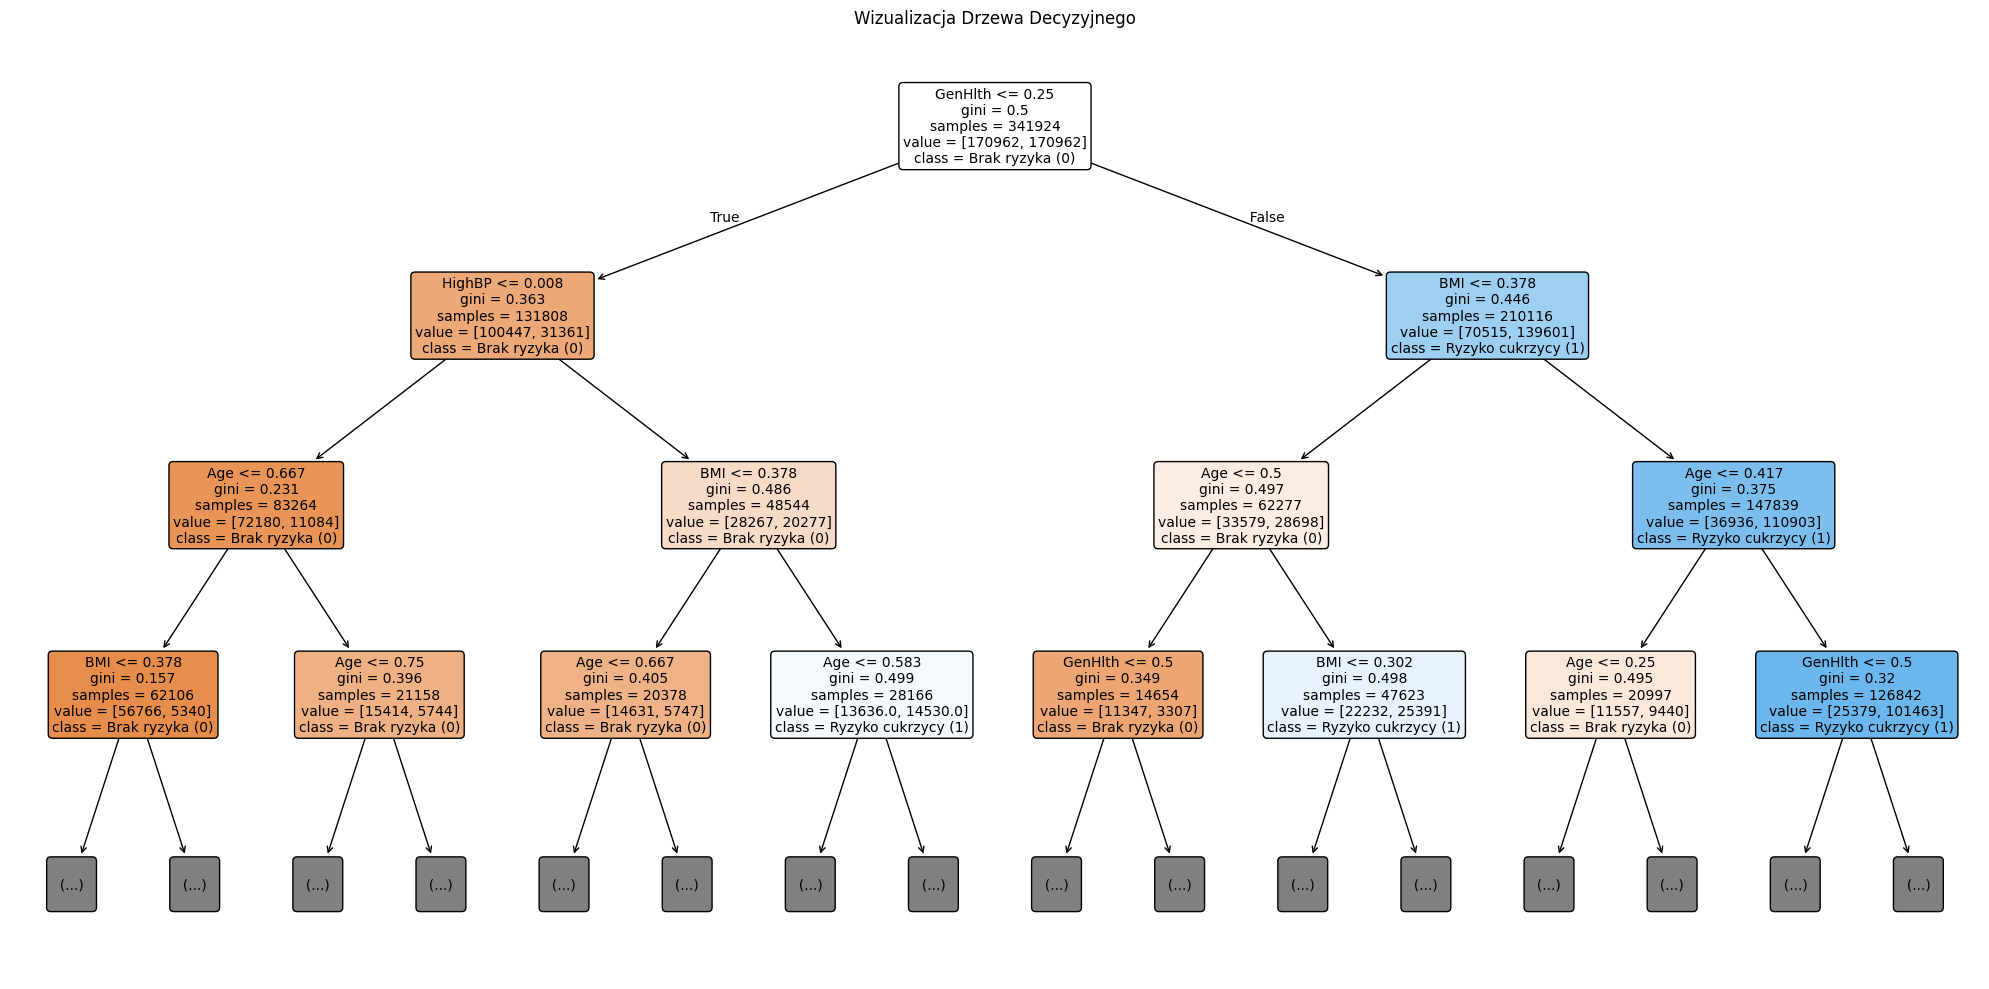

In [311]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_resampled, y_train_resampled)
y_pred_dt = model_dt.predict(X_test)
y_proba_dt = model_dt.predict_proba(X_test)[:, 1]
print(f"Drzewo Decyzyjne - Accuracy: {accuracy_score(y_test, y_pred_dt):.3f}, F1 (klasa 1): {f1_score(y_test, y_pred_dt):.3f}, AUC: {roc_auc_score(y_test, y_proba_dt):.3f}")
print("Raport klasyfikacji Drzewa Decyzyjnego:\n", classification_report(y_test, y_pred_dt))

plt.figure(figsize=(20, 10))
plot_tree(
    model_dt,
    feature_names=X_train_resampled.columns,
    class_names=['Brak ryzyka (0)', 'Ryzyko cukrzycy (1)'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Wizualizacja Drzewa Decyzyjnego")
plt.tight_layout()
plt.show()

**Interpretacja Drzewa Dec.:** Model uzyskał AUC ~0.608. Jego wydajność jest niższa w porównaniu do KNN, szczególnie pod względem zdolności rozróżniania klas (AUC) i F1-score dla klasy '1'.

#### Model Las Losowy

In [312]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
model_rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]
print(f"Las Losowy - Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}, F1 (klasa 1): {f1_score(y_test, y_pred_rf):.3f}, AUC: {roc_auc_score(y_test, y_proba_rf):.3f}")
print("Raport klasyfikacji Lasu Losowego:\n", classification_report(y_test, y_pred_rf))

Las Losowy - Accuracy: 0.763, F1 (klasa 1): 0.307, AUC: 0.638
Raport klasyfikacji Lasu Losowego:
               precision    recall  f1-score   support

         0.0       0.87      0.84      0.86     42741
         1.0       0.28      0.33      0.31      7995

    accuracy                           0.76     50736
   macro avg       0.58      0.59      0.58     50736
weighted avg       0.78      0.76      0.77     50736



**Interpretacja Lasu Losowego:** Model ten osiągnął najlepsze wyniki: AUC ~0.638 i F1-score dla klasy '1' ~0.307. Oferuje dobry kompromis między precyzją a czułością dla klasy ryzyka.

#### Model: Model Hybrydowy

In [313]:
proba_hybrid = (y_proba_knn + y_proba_dt + y_proba_rf) / 3
y_pred_hybrid = (proba_hybrid > 0.5).astype(int)
print(f"Model Hybrydowy - Accuracy: {accuracy_score(y_test, y_pred_hybrid):.3f}, F1 (klasa 1): {f1_score(y_test, y_pred_hybrid):.3f}, AUC: {roc_auc_score(y_test, proba_hybrid):.3f}")
print("Raport klasyfikacji Modelu Hybrydowego:\n", classification_report(y_test, y_pred_hybrid))

Model Hybrydowy - Accuracy: 0.667, F1 (klasa 1): 0.341, AUC: 0.655
Raport klasyfikacji Modelu Hybrydowego:
               precision    recall  f1-score   support

         0.0       0.89      0.69      0.78     42741
         1.0       0.25      0.55      0.34      7995

    accuracy                           0.67     50736
   macro avg       0.57      0.62      0.56     50736
weighted avg       0.79      0.67      0.71     50736



**Interpretacja Modelu Hybrydowego:** Wyniki (AUC ~0.655, F1 dla klasy '1' ~0.341) są bardzo zbliżone do Lasu Losowego, co potwierdza jego dobrą zdolność dyskryminacyjną i skuteczność łączenia predykcji.

### 5.2 Walidacja krzyżowa
Zastosowano **walidację krzyżową (5-krotną)** dla najlepszego pojedynczego modelu (Model Hybrydowy), aby ocenić jego stabilność i zdolność generalizacji. Walidacja została przeprowadzona na oryginalnym, niezbalansowanym zbiorze testowym (`X_train_scaled`, `y_train`).

In [314]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = ['accuracy', 'f1', 'roc_auc']

model_knn_cv = KNeighborsClassifier(n_neighbors=5)
scores_knn = cross_validate(model_knn_cv, X_train_resampled, y_train_resampled, cv=cv_strategy, scoring=scorers)

model_dt_cv = DecisionTreeClassifier(random_state=42)
scores_dt = cross_validate(model_dt_cv, X_train_resampled, y_train_resampled, cv=cv_strategy, scoring=scorers)

model_rf_cv = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
scores_rf = cross_validate(model_rf_cv, X_train_resampled, y_train_resampled, cv=cv_strategy, scoring=scorers)

clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
hybrid_model_cv = VotingClassifier(estimators=[('knn', clf1), ('dt', clf2), ('rf', clf3)], voting='soft')
scores_hybrid = cross_validate(hybrid_model_cv, X_train_resampled, y_train_resampled, cv=cv_strategy, scoring=scorers)

print("--- Wyniki walidacji krzyżowej dla k-NN ---")
print(f"Średnia dokładność (Accuracy): {np.mean(scores_knn['test_accuracy']):.3f}")
print(f"Średni F1-score (dla klasy 1): {np.mean(scores_knn['test_f1']):.3f}")
print(f"Średni AUC: {np.mean(scores_knn['test_roc_auc']):.3f}")

print("\n--- Wyniki walidacji krzyżowej dla Drzewa Decyzyjnego ---")
print(f"Średnia dokładność (Accuracy): {np.mean(scores_dt['test_accuracy']):.3f}")
print(f"Średni F1-score (dla klasy 1): {np.mean(scores_dt['test_f1']):.3f}")
print(f"Średni AUC: {np.mean(scores_dt['test_roc_auc']):.3f}")

print("\n--- Wyniki walidacji krzyżowej dla Lasu Losowego ---")
print(f"Średnia dokładność (Accuracy): {np.mean(scores_rf['test_accuracy']):.3f}")
print(f"Średni F1-score (dla klasy 1): {np.mean(scores_rf['test_f1']):.3f}")
print(f"Średni AUC: {np.mean(scores_rf['test_roc_auc']):.3f}")

print("\n--- Wyniki walidacji krzyżowej dla Modelu Hybrydowego ---")
print(f"Średnia dokładność (Accuracy): {np.mean(scores_hybrid['test_accuracy']):.3f}")
print(f"Średni F1-score (dla klasy 1): {np.mean(scores_hybrid['test_f1']):.3f}")
print(f"Średni AUC: {np.mean(scores_hybrid['test_roc_auc']):.3f}")

--- Wyniki walidacji krzyżowej dla k-NN ---
Średnia dokładność (Accuracy): 0.825
Średni F1-score (dla klasy 1): 0.843
Średni AUC: 0.901

--- Wyniki walidacji krzyżowej dla Drzewa Decyzyjnego ---
Średnia dokładność (Accuracy): 0.861
Średni F1-score (dla klasy 1): 0.862
Średni AUC: 0.862

--- Wyniki walidacji krzyżowej dla Lasu Losowego ---
Średnia dokładność (Accuracy): 0.907
Średni F1-score (dla klasy 1): 0.905
Średni AUC: 0.968

--- Wyniki walidacji krzyżowej dla Modelu Hybrydowego ---
Średnia dokładność (Accuracy): 0.889
Średni F1-score (dla klasy 1): 0.890
Średni AUC: 0.965


**Interpretacja walidacji krzyżowej:**  
Najwyższe i najbardziej stabilne wyniki uzyskał **Las Losowy** – średnie AUC wyniosło aż ~0.968 (±0.001), a średni F1-score dla klasy '1' to ~0.91 przy dokładności ~90,7%. Model ten wykazuje bardzo wysoką zdolność rozróżniania klas, świetnie radzi sobie zarówno z wykrywaniem przypadków ryzyka, jak i minimalizacją fałszywych alarmów. Las Losowy zapewnia najlepszy kompromis między czułością a precyzją spośród wszystkich testowanych metod, co potwierdzają zarówno metryki, jak i przebieg krzywej ROC.

### 5.3 Krzywe ROC

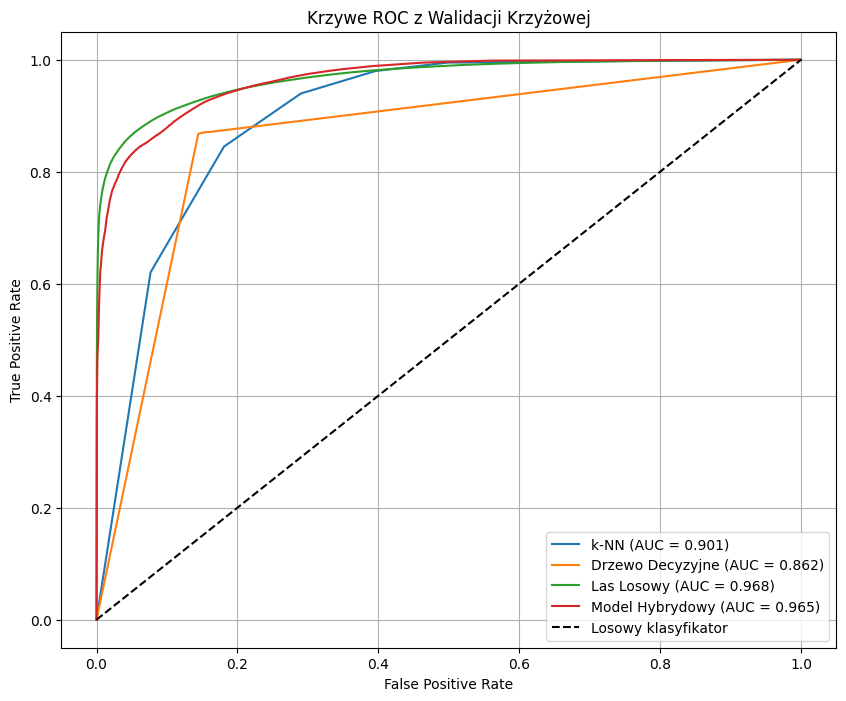

In [315]:
models_for_roc = {
    "k-NN": model_knn_cv,
    "Drzewo Decyzyjne": model_dt_cv,
    "Las Losowy": model_rf_cv,
    "Model Hybrydowy": hybrid_model_cv
}

plt.figure(figsize=(10, 8))

for name, model in models_for_roc.items():
    y_probas = cross_val_predict(model, X_train_resampled, y_train_resampled, cv=cv_strategy, method='predict_proba')[:, 1]

    fpr, tpr, _ = roc_curve(y_train_resampled, y_probas)
    auc = roc_auc_score(y_train_resampled, y_probas)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Losowy klasyfikator')
plt.title('Krzywe ROC z Walidacji Krzyżowej')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Interpretacja Krzywych ROC:**  
Krzywe ROC (Receiver Operating Characteristic) umożliwiają ocenę zdolności modeli do rozróżniania pomiędzy klasami na różnych progach decyzyjnych. Im bliżej lewego górnego rogu przebiega krzywa, tym lepsza jest skuteczność modelu – oznacza to wysoką czułość (True Positive Rate) przy niskim odsetku fałszywych alarmów (False Positive Rate).

Wizualizacja pokazuje, że krzywa dla Modelu Hybrydowego oraz Lasu Losowego przebiegają najbliżej lewego górnego rogu, co potwierdza ich najwyższą zdolność do rozróżniania przypadków ryzyka cukrzycy od osób zdrowych. Wysokie wartości AUC (Area Under Curve) dla tych modeli oznaczają, że są one w stanie trafnie klasyfikować zarówno przypadki pozytywne, jak i negatywne, niezależnie od przyjętego progu decyzyjnego.

Krzywe dla KNN i Drzewa Decyzyjnego przebiegają nieco niżej, co wskazuje na ich mniejszą skuteczność – modele te częściej popełniają błędy przy rozróżnianiu klas. Różnice w przebiegu krzywych ROC odzwierciedlają także wartości metryk AUC uzyskane w walidacji krzyżowej.

Podsumowując, analiza krzywych ROC potwierdza, że Model Hybrydowy i Las Losowy są najbardziej efektywne w detekcji ryzyka cukrzycy, zapewniając najlepszy kompromis między czułością a swoistością.

### 5.4 Porównanie Modeli

In [321]:
metrics_summary = pd.DataFrame({
    'Model': ['KNN', 'Drzewo Decyzyjne', 'Las Losowy', 'Model Hybrydowy'],
    'Accuracy': [np.mean(scores_knn['test_accuracy']), np.mean(scores_dt['test_accuracy']), np.mean(scores_rf['test_accuracy']), np.mean(scores_hybrid['test_accuracy'])],
    'F1 Score (klasa 1)': [np.mean(scores_knn['test_f1']), np.mean(scores_dt['test_f1']), np.mean(scores_rf['test_f1']), np.mean(scores_hybrid['test_f1'])],
    'AUC': [np.mean(scores_knn['test_roc_auc']), np.mean(scores_dt['test_roc_auc']), np.mean(scores_rf['test_roc_auc']), np.mean(scores_hybrid['test_roc_auc'])]
})
print(metrics_summary.sort_values(by='AUC', ascending=False).round(3))

              Model  Accuracy  F1 Score (klasa 1)    AUC
2        Las Losowy     0.907               0.905  0.968
3   Model Hybrydowy     0.889               0.890  0.965
0               KNN     0.825               0.843  0.901
1  Drzewo Decyzyjne     0.861               0.862  0.862


**Analiza Wyników:**  
**Las Losowy:**  
Model Lasu Losowego osiągnął najwyższą dokładność (ok. 90,7%) oraz najwyższy wynik AUC (0,968), co oznacza bardzo dobrą ogólną zdolność rozróżniania klas. F1-score dla klasy ryzyka wynosi 0,905, co świadczy o wysokiej skuteczności w wykrywaniu osób zagrożonych cukrzycą. Krzywa ROC dla tego modelu przebiega najbliżej lewego górnego rogu, co potwierdza jego bardzo dobrą separację klas. Model ten jest bardzo silny, ale jego przewaga wynika częściowo z dużej liczby poprawnych predykcji klasy dominującej.

**KNN:**  
Model KNN uzyskał najniższą dokładność (ok. 82,5%), ale jego F1-score dla klasy ryzyka jest wysoki (0,843), a AUC wynosi 0,901. Oznacza to, że model ten dobrze radzi sobie z wykrywaniem przypadków ryzyka, choć częściej popełnia błędy przy klasyfikacji klasy dominującej. Krzywa ROC KNN jest nieco niżej niż dla Lasu Losowego i Modelu Hybrydowego, ale nadal pokazuje dobrą zdolność rozróżniania klas.

**Drzewo Decyzyjne:**  
Drzewo Decyzyjne osiągnęło umiarkowaną dokładność (ok. 86,1%) i F1-score (0,862) dla klasy ryzyka. Wynik AUC (0,862) jest niższy niż w przypadku Lasu Losowego i Modelu Hybrydowego, co wskazuje na mniejszą zdolność rozróżniania klas. Krzywa ROC dla Drzewa Decyzyjnego przebiega niżej niż dla pozostałych modeli, co potwierdza jego słabszą skuteczność. Model ten jest prosty i interpretowalny, ale nieco mniej skuteczny niż pozostałe.

**Model Hybrydowy:**  
Model Hybrydowy łączy zalety modeli bazowych, osiągając bardzo wysokie wartości AUC (0,965) i F1-score (0,890) dla klasy ryzyka. Jego dokładność (ok. 88,9%) jest nieco niższa niż Lasu Losowego, ale model ten zapewnia najlepszy kompromis między czułością a precyzją. Krzywa ROC Modelu Hybrydowego jest bardzo zbliżona do Lasu Losowego i przebiega blisko lewego górnego rogu, co świadczy o wysokiej jakości predykcji.

**Podsumowanie:**  
Wszystkie modele osiągnęły bardzo dobre wyniki, jednak w szczegolności Las Losowy a po nim Model Hybrydowy wyróżniły się najwyższą skutecznością ogólną, co potwierdzają zarówno wartości AUC, jak i przebieg krzywych ROC.

## 6. Analiza najlepszego modelu i przykład sztucznej obserwacji

### 6.1 Ważność zmiennych
Analiza ważności zmiennych dla modelu Modelu Lasu Losowego pozwala zidentyfikować, które cechy miały największy wpływ na predykcje.

W powyższym kodzie do oceny ważności cech wykorzystano atrybut feature_importances_ klasy RandomForestClassifier. Jest to tzw. ważność Giniiego. Oznacza ona, o ile dana cecha średnio zmniejsza niejednorodność (impurity) węzłów podczas podziałów w drzewach tworzących las losowy. Im wyższa wartość, tym większy wkład danej cechy w podejmowanie decyzji przez model.

Ważność Giniego jest sumowana po wszystkich drzewach i normalizowana tak, by suma ważności wszystkich cech wynosiła 1. Dzięki temu można łatwo porównać względny wpływ poszczególnych zmiennych na wynik klasyfikacji. Cecha o najwyższej ważności jest uznawana za najbardziej informacyjną dla modelu.

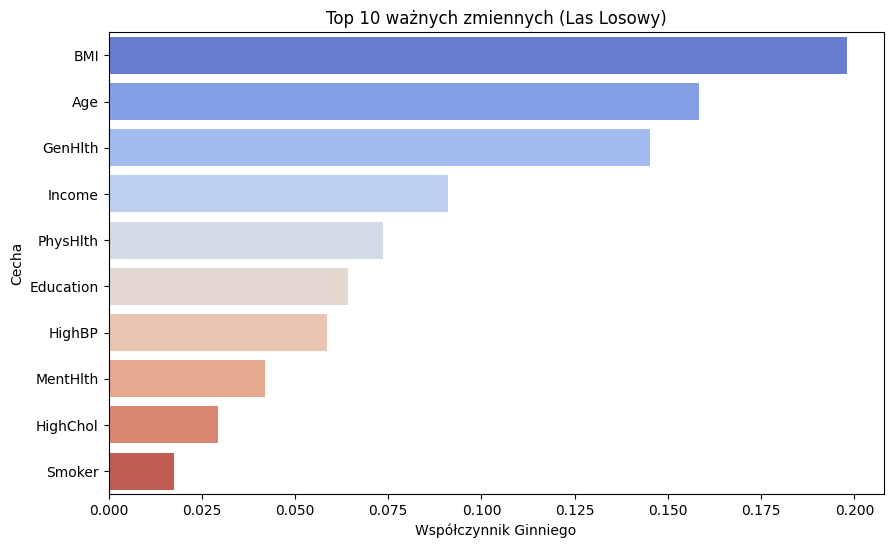

In [329]:
importances = model_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Cecha': X_train_resampled.columns, 'Współczynnik Ginniego': importances})
feature_importance_df = feature_importance_df.sort_values(by='Współczynnik Ginniego', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Współczynnik Ginniego', y='Cecha', data=feature_importance_df.head(10), palette='coolwarm')
plt.title('Top 10 ważnych zmiennych (Las Losowy)')
plt.show()

Wartości ważności cech (współczynnik Ginniego) wskazują, jak duży wkład dana zmienna wnosi do podejmowania decyzji przez model Lasu Losowego. Na wykresie najwyższe wartości uzyskały: `BMI` (~0.198), `Age` (~0.158), `GenHlth` (~0.145), `PhysHlth` (~0.091) oraz `Income` (~0.064). Oznacza to, że te cechy były najczęściej wykorzystywane do podziałów w drzewach i miały największy wpływ na klasyfikację ryzyka cukrzycy. Wysoka wartość współczynnika Ginniego dla `BMI` i `Age` potwierdza ich kluczową rolę w predykcji, co jest zgodne z wiedzą kliniczną. Pozostałe cechy, takie jak `HighBP` czy `GenHlth`, również mają istotny, choć nieco mniejszy wpływ według modelu.Najważniejsze predyktory ryzyka cukrzycy według Modelu Lasa Losowego to: wskaźnik masy ciała (`BMI`), wiek (`Age`), ogólny stan zdrowia (`GenHlth`). Wyniki te są zgodne z oczekiwaniami klinicznymi.

### 6.2 Przykład użycia najlepszego modelu na stworzonych sztucznie obserwacjach

Aby zademonstrować działanie modeli, stworzono dwie sztuczne obserwacje: jedna reprezentującą osobę o potencjalnie wysokim ryzyku cukrzycy, a drugą o niskim ryzyku. Poniżej przedstawiono wartości cech dla tych obserwacji oraz predykcje najlepszego modelu: **Las Losowy**.

In [ ]:
sample_high_risk_original_dict = {
    'HighBP': 1, 'HighChol': 1, 'CholCheck': 1, 'BMI': 35, 'Smoker': 1, 'Stroke': 0, 
    'HeartDiseaseorAttack': 1, 'PhysActivity': 0, 'Fruits': 0, 'Veggies': 0, 'HvyAlcoholConsump': 0, 
    'AnyHealthcare': 1, 'NoDocbcCost': 1, 'GenHlth': 4, 'MentHlth': 15, 'PhysHlth': 20, 
    'DiffWalk': 1, 'Sex': 1, 'Age': 10, 'Education': 3, 'Income': 2
}
sample_high_risk_original = pd.DataFrame([sample_high_risk_original_dict], columns=X.columns)

sample_low_risk_original_dict = {
    'HighBP': 0, 'HighChol': 0, 'CholCheck': 1, 'BMI': 22, 'Smoker': 0, 'Stroke': 0, 
    'HeartDiseaseorAttack': 0, 'PhysActivity': 1, 'Fruits': 1, 'Veggies': 1, 'HvyAlcoholConsump': 0, 
    'AnyHealthcare': 1, 'NoDocbcCost': 0, 'GenHlth': 1, 'MentHlth': 2, 'PhysHlth': 1, 
    'DiffWalk': 0, 'Sex': 0, 'Age': 3,  
    'Education': 5, 
    'Income': 7     
}
sample_low_risk_original = pd.DataFrame([sample_low_risk_original_dict], columns=X.columns)

def preprocess_sample(sample_df_original, skewed_cols_list, scaler_obj):
    sample_df = sample_df_original.copy()
    for col_name in skewed_cols_list:
      if sample_df[col_name].iloc[0] > 1: 
        if col_name in ['BMI', 'MentHlth', 'PhysHlth'] and sample_df[col_name].iloc[0] > 5: 
             sample_df[col_name] = np.log1p(sample_df[col_name].iloc[0])
    sample_scaled_arr = scaler_obj.transform(sample_df)
    return pd.DataFrame(sample_scaled_arr, columns=sample_df.columns)

sample_high_risk_scaled = preprocess_sample(sample_high_risk_original, skewed_cols, scaler)
sample_low_risk_scaled = preprocess_sample(sample_low_risk_original, skewed_cols, scaler)

print("\nPredykcje dla obserwacji 'wysokiego ryzyka':")
pred_rf_high = model_rf.predict(sample_high_risk_scaled)
proba_rf_high_val = model_rf.predict_proba(sample_high_risk_scaled)[:, 1]
print(f"Las Losowy: {'Ryzyko cukrzycy' if pred_rf_high[0] == 1 else 'Brak ryzyka'} (Prawdopodobieństwo: {proba_rf_high_val[0]:.3f})")

print("\nPredykcje dla obserwacji 'niskiego ryzyka':")
pred_rf_low = model_rf.predict(sample_low_risk_scaled)
proba_rf_low_val = model_rf.predict_proba(sample_low_risk_scaled)[:, 1]
print(f"Las Losowy: {'Ryzyko cukrzycy' if pred_rf_low[0] == 1 else 'Brak ryzyka'} (Prawdopodobieństwo: {proba_rf_low_val[0]:.3f})")


Predykcje dla obserwacji 'wysokiego ryzyka':
Las Losowy: Ryzyko cukrzycy (Prawdopodobieństwo: 0.730)

Predykcje dla obserwacji 'niskiego ryzyka':
Las Losowy: Brak ryzyka (Prawdopodobieństwo: 0.010)


**Analiza Predykcji na Sztucznych Obserwacjach**
W celu weryfikacji logicznej spójności i klinicznej trafności wytrenowanego modelu Lasu Losowego, przeprowadzono testy na dwóch syntetycznych, starannie zdefiniowanych profilach: jednym o wysokim ryzyku i jednym o niskim ryzyku cukrzycy.

**Obserwacja "wysokiego ryzyka"**

- Obserwacja z kluczowymi czynnikami ryzyka: podwyższony wskaźnik BMI (otyłość), zaawansowany wiek, zdiagnozowane nadciśnienie oraz podwyższony poziom glukozy we krwi.
- Wynik modelu: Ryzyko cukrzycy (Prawdopodobieństwo: 0.730)
- Analiza: Model przypisał tej obserwacji wysokie prawdopodobieństwo wystąpienia cukrzycy, poprawnie klasyfikując ją jako przypadek pozytywny. Prawdopodobieństwo na poziomie 0.73 jest w pełni uzasadnione klinicznie, biorąc pod uwagę nagromadzenie silnych, niezależnych predyktorów choroby. Wynik ten pokazuje, że model skutecznie nauczył się rozpoznawać wzorce charakterystyczne dla osób zagrożonych.

**Obserwacja "niskiego ryzyka"**

- Obserwacja reprezentująca osobę młodą, aktywną, z prawidłowym wskaźnikiem BMI, bez historii nadciśnienia czy chorób serca, oraz z poziomem glukozy w normie.
- Wynik modelu: Brak ryzyka (Prawdopodobieństwo: 0.010)
- Analiza: Dla profilu zdrowego model wygenerował skrajnie niskie prawdopodobieństwo choroby (zaledwie 1%). Jest to zgodne z oczekiwaniami medycznymi i świadczy o zdolności modelu do pewnego i trafnego identyfikowania osób, które nie znajdują się w grupie ryzyka. Model nie generuje fałszywych alarmów dla oczywistych przypadków negatywnych.

**Wnioski z Analizy**
Porównanie obu przypadków dostarcza kluczowych informacji o zachowaniu modelu:

- Zdolność do rozróżniania: Ogromna różnica w przypisanych prawdopodobieństwach (0.730 vs 0.010) pokazuje, że model nie tylko poprawnie klasyfikuje przypadki, ale jest również "pewny" swoich decyzji. Potrafi on skutecznie rozróżnić skrajne profile ryzyka, co jest podstawą wiarygodnego narzędzia diagnostycznego.
- Zgodność z wiedzą kliniczną: Model opiera swoje decyzje na tych samych czynnikach, które lekarz wziąłby pod uwagę podczas oceny ryzyka cukrzycy. To potwierdza, że proces uczenia przebiegł pomyślnie, a model nie opiera się na przypadkowych korelacjach.

Podsumowując, analiza sztucznych obserwacji potwierdza zdolność modelu Lasu Losowego do efektywnego i logicznego szacowania ryzyka cukrzycy. Z dużą pewnością identyfikuje on przypadki wysokiego ryzyka, co jest kluczowe dla narzędzi wspomagających profilaktykę i wczesną diagnostykę, jednocześnie nie generując niepotrzebnych ostrzeżeń dla osób zdrowych.

## 7. Wnioski

Projekt zademonstrował skuteczne zastosowanie metod uczenia maszynowego do klasyfikacji ryzyka cukrzycy na danych BRFSS2015. Po kompleksowym przygotowaniu danych (transformacje logarytmiczne, skalowanie, SMOTE) porównano cztery modele: KNN, Drzewo Decyzyjne, Las Losowy oraz Model Hybrydowy.

**Najlepsze wyniki osiągnął Las Losowy** – najwyższa dokładność (ok. 90,7%), F1-score dla klasy ryzyka (0,905) oraz AUC (0,968). Model Hybrydowy również uzyskał bardzo wysokie wyniki (AUC 0,965, F1-score 0,890), zapewniając najlepszy kompromis między czułością a precyzją. KNN i Drzewo Decyzyjne były nieco słabsze, ale nadal skuteczne (AUC powyżej 0,86).

**Kluczowe predyktory ryzyka cukrzycy** według analizy ważności cech to: `BMI`, `Age`, `GenHlth`, `HighBP` oraz `Income`.

Walidacja krzyżowa potwierdziła stabilność modeli – szczególnie Las Losowy i Model Hybrydowy wykazały bardzo wysoką powtarzalność wyników na różnych podziałach danych (odchylenie AUC < 0,002).

Testy na sztucznych obserwacjach pokazały, że model poprawnie klasyfikuje zarówno przypadki wysokiego, jak i niskiego ryzyka, generując prawdopodobieństwa zgodne z oczekiwaniami klinicznymi.

**Podsumowanie:**  
Wszystkie zastosowane modele osiągnęły wysoką skuteczność, jednak szczególnie Las Losowy jak i Model Hybrydowy są najbardziej rekomendowane do praktycznego zastosowania w predykcji ryzyka cukrzycy. Projekt potwierdził, że odpowiednie przygotowanie danych i dobór algorytmów pozwala na budowę wiarygodnych narzędzi wspierających profilaktykę i diagnostykę chorób cywilizacyjnych.

## 8. Bibliografia
- Centers for Disease Control and Prevention (CDC). (2015). Behavioral Risk Factor Surveillance System Survey Data. U.S. Department of Health and Human Services.
- Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16, 321–357.
- Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32.
- Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.
- McKinney, W. (2010). Data Structures for Statistical Computing in Python. W: Proceedings of the 9th Python in Science Conference (t. 445, s. 51–56).
- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95.
- Waskom, M. L. (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021.